참고 : https://coding-yoon.tistory.com/131
https://limitsinx.tistory.com/144


1. 라이브러리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device
print(torch.cuda.get_device_name(0))

Tesla K80


2. padas_datareader를 이용하여 주식 불러오기

In [ ]:
# pandas datareader를 설치합니다.
!pip install pandas-datareader
import pandas_datareader.data as pdr
import datetime

네이버 주가
https://finance.yahoo.com/quote/035420.KS?p=035420.KS&.tsrc=fin-srch

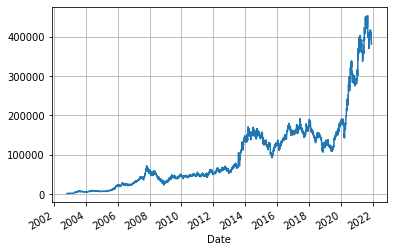

In [ ]:
start = (2000, 1, 1) # 2020년 01년 01월 
start = datetime.datetime(*start)
end = datetime.date.today() # 현재

# yahoo 에서 네이버 불러오기
df = pdr.DataReader('035420.KS', 'yahoo', start, end)
df.head(5)
df.tail(5)
df.Close.plot(grid=True)

In [ ]:
#드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.to_excel('/content/drive/My Drive/NAVER.xlsx')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-10-29,1797.724854,1797.724854,1797.724854,1797.724854,501745.0,1763.380981
2002-10-30,2012.226074,1989.754517,2012.226074,2012.226074,20892185.0,1973.784546
2002-10-31,2091.897949,1865.139526,2042.869141,1912.125488,32327083.0,1875.596313
2002-11-01,2022.440430,1724.181519,1961.154419,1793.639038,18373668.0,1759.373291
2002-11-04,1789.553345,1660.852539,1777.296143,1703.752808,16939411.0,1671.204102
...,...,...,...,...,...,...
2021-11-24,401000.000000,392000.000000,399000.000000,395000.000000,554151.0,395000.000000
2021-11-25,401000.000000,395500.000000,400000.000000,397000.000000,323058.0,397000.000000
2021-11-26,395500.000000,388000.000000,394000.000000,389500.000000,473540.0,389500.000000


3. 데이터셋 준비하기


In [ ]:
""" 
open 시가
high 고가
low 저가
close 종가
volume 거래량
Adj Close 주식의 분할, 배당, 배분 등을 고려해 조정한 종가
"""

X = df.drop(columns='Volume') #거래량 drop
print(X)

                     High            Low  ...          Close      Adj Close
Date                                      ...                              
2002-10-29    1797.724854    1797.724854  ...    1797.724854    1763.380981
2002-10-30    2012.226074    1989.754517  ...    2012.226074    1973.784546
2002-10-31    2091.897949    1865.139526  ...    1912.125488    1875.596313
2002-11-01    2022.440430    1724.181519  ...    1793.639038    1759.373291
2002-11-04    1789.553345    1660.852539  ...    1703.752808    1671.204102
...                   ...            ...  ...            ...            ...
2021-11-24  401000.000000  392000.000000  ...  395000.000000  395000.000000
2021-11-25  401000.000000  395500.000000  ...  397000.000000  397000.000000
2021-11-26  395500.000000  388000.000000  ...  389500.000000  389500.000000
2021-11-29  391500.000000  382500.000000  ...  386500.000000  386500.000000
2021-11-30  392500.000000  381000.000000  ...  381000.000000  381000.000000

[4765 rows 

In [ ]:
y = df.iloc[:, 5:6] #종가
print(y)

                Adj Close
Date                     
2002-10-29    1763.380981
2002-10-30    1973.784546
2002-10-31    1875.596313
2002-11-01    1759.373291
2002-11-04    1671.204102
...                   ...
2021-11-24  395000.000000
2021-11-25  397000.000000
2021-11-26  389500.000000
2021-11-29  386500.000000
2021-11-30  381000.000000

[4765 rows x 1 columns]


In [ ]:
"""
학습이 잘되기 위해 데이터 정규화
StandardScaler 각 특징의 평균을 0, 분산을 1이 되도록 변경
MinMaxScaler 최대/최소값이 각각 1, 0이 되도록 변경
"""

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

# Train Data
X_train = X_ss[:4000, :]
X_test = X_ss[4000:, :]

# Test Data 
y_train = y_mm[:4000, :] 
y_test = y_mm[4000:, :]
print("Training Shape", X_train.shape, y_train.shape) 
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (4000, 5) (4000, 1)
Testing Shape (765, 5) (765, 1)


In [ ]:
# 학습할 수 있는 형태로 변환하기 위해 Torch로 변환
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1])) 
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape) 
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([4000, 1, 5]) torch.Size([4000, 1])
Testing Shape torch.Size([765, 1, 5]) torch.Size([765, 1])


4. LSTM 네트워크 구성하기

In [ ]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
    
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 = nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer
    
    self.relu = nn.ReLU()
  
  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state
    
    # Propagate input through LSTM
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
    
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output return out

5. LSTM 파라미터 구성하기

In [ ]:
num_epochs = 1000
learning_rate = 0.001

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss() # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) # adam optimizer

In [ ]:
lstm1

LSTM1(
  (lstm): LSTM(5, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_function

MSELoss()

6. Train

In [ ]:
outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass 

In [ ]:
print(outputs)

None


In [ ]:
for epoch in range(num_epochs): 
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass 
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0 
  
  # obtain the loss function 
  loss = loss_function(outputs, y_train_tensors.to(device))
  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop

  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

7. 예측하기

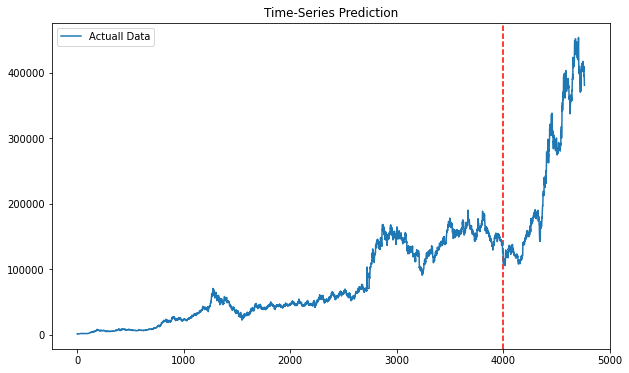

In [ ]:
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:, 5:6])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

# Estimated Value
train_predict = lstm1(df_X_ss.to(device))#forward pass
# data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

# Figure
# data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4000, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
# plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 